# Setup

In [1]:
import pymongo
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta
from iso8601 import parse_date

sns.set_theme(style="darkgrid")

season_start = parse_date("2021-08-13T22:43:02.813Z") - timedelta(minutes=30)
season_end = parse_date("2021-08-20T21:12:34.005Z") + timedelta(minutes=30)

client = pymongo.MongoClient()
db = client.tpp3
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}})
data = pd.DataFrame(list(collection))

data = data.drop(["game","avatars","teams","base_metagames","base_gimmicks"],axis=1)

data.result = pd.to_numeric(data.result, errors="coerce")

data["duration"] = data.finished_at - data.started_at
data = data.drop(["started_at","finished_at","created_at"],axis=1)

data[["odds","blue_odds"]] = pd.DataFrame(data.pokeyen_odds.to_list(), index=data.index)
data["winner_odds"] = [data.odds[i] if result==1 else data.blue_odds[i] for i,result in enumerate(data["result"])]
data = data.drop(["pokeyen_odds","blue_odds"],axis=1)

data["num_bettors"] = data.pokeyen_bets.str.len() # magic I guess
data = data.drop(["pokeyen_bets"], axis=1)

# TODO there has to be a better way
average_bet = []
total_bonus = []
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}}) # it broke without resetting collection here
for i, match in enumerate(collection):
    average_bet.append(0.0 if len(match["pokeyen_bets"]) == 0
        else statistics.mean(v["amount"] for v in match["pokeyen_bets"].values()))
    total_bonus.append(0.0 if len(match["pokeyen_bets"]) == 0 or match["result"] == None
        else (sum(bet["amount"]*bet["bet_bonus"]/100 for bet in match["pokeyen_bets"].values() if bet["team"] == match["result"])))
data["average_bet"] = pd.DataFrame(average_bet)
data["bet_bonus_amount"] = pd.DataFrame(total_bonus)
del average_bet

nonzero_bets = data[data.average_bet > 0]

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   _id               941 non-null    int64          
 1   result            935 non-null    float64        
 2   stage             941 non-null    object         
 3   metagame          941 non-null    object         
 4   gimmick           941 non-null    object         
 5   switching         941 non-null    object         
 6   custom            941 non-null    bool           
 7   bet_bonus_type    941 non-null    object         
 8   bet_bonus_cap     0 non-null      object         
 9   duration          941 non-null    timedelta64[ns]
 10  odds              941 non-null    float64        
 11  winner_odds       941 non-null    float64        
 12  num_bettors       941 non-null    int64          
 13  average_bet       941 non-null    float64        
 14  bet_bonus_

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
0,186309,0.0,stargazer,color_clash,hidden_bets+manvsmachine_autogenerated,never,False,bet,None,0 days 00:06:11.941000,0.405194,2.467951,13,886.461538,0.000000
1,186310,0.0,neon,advanced,manvsmachine,never,False,bet,None,0 days 00:04:40.110000,0.562225,1.778647,20,799.000000,0.000000
2,186311,0.0,waterfall,simple,manvsmachine,never,False,bet,None,0 days 00:07:29.246000,0.134165,7.453517,21,1316.333333,0.000000
3,186312,1.0,crystal,little_cup,singles_combo_of_2+manvsmachine_autogenerated,never,False,bet,None,0 days 00:03:20.524000,3.213146,3.213146,13,670.538462,0.000000
4,186313,0.0,waterfall,type_warfare,manvsmachine,never,True,bet,None,0 days 00:09:33.065000,0.022432,44.579157,24,10496.500000,16721.950074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,187045,0.0,crystal,simple,manvsmachine,never,False,bet,None,0 days 00:06:24.439000,0.246504,4.056729,25,2652.760000,0.000000
937,187046,0.0,sunny_park,anime,inverse+manvsmachine_autogenerated,never,False,bet,None,0 days 00:09:24.296000,0.160916,6.214424,23,1787.608696,0.000000
938,187047,0.0,gateway,pwt,manvsmachine,never,False,bet,None,0 days 00:07:25.646000,0.253343,3.947214,26,2393.500000,0.000000
939,187048,1.0,magma,dubers,doubles_inputting_combo_of_2+manvsmachine_auto...,never,False,bet,None,0 days 00:02:14.621000,0.446703,0.446703,27,1644.740741,0.000000


# Highlights 

### Match with the least bidders

In [2]:
data[data.num_bettors == data.num_bettors.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
12,186321,0.0,sunset,simple,hidden_bets+manvsmachine_autogenerated,never,False,bet,None,0 days 00:06:39.921000,4.230000,0.236407,7,224.142857,0.000000
407,186716,0.0,waterfall,color_clash,doubles+manvsmachine_autogenerated,never,False,bet,None,0 days 00:07:46.610000,1.133333,0.882353,7,457.142857,0.000000
583,186821,0.0,magma,runmons,doubles+manvsmachine_autogenerated,never,True,bet,None,0 days 00:08:15.708000,0.065372,15.297143,7,814.857143,74.299359
616,186839,0.0,magma,simple,manvsmachine,never,False,bet,None,0 days 00:08:15.319000,410.250000,0.002438,7,235.000000,0.000000
645,186851,1.0,neon,simple,manvsmachine,never,False,bet,None,0 days 00:05:33.160000,1.052632,1.052632,7,278.571429,0.000000
859,186968,1.0,sunny_park,dubers,doubles_inputting_combo_of_3+manvsmachine_auto...,never,False,bet,None,0 days 00:04:14.808000,1.066667,1.066667,7,442.857143,0.000000


### Match with the lowest average bet

In [3]:
data[data.average_bet == data.average_bet.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
12,186321,0.0,sunset,simple,hidden_bets+manvsmachine_autogenerated,never,False,bet,None,0 days 00:06:39.921000,4.23,0.236407,7,224.142857,0.0


### Match with the lowest Red odds

In [4]:
data[data.odds == data.odds.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
512,186148,1.0,lagoon,runmons,manvsmachine,never,True,bet,None,0 days 00:03:41.320000,72080.0,72080.0,22,3276.409091,0.0


### Match with the most bidders

In [5]:
data[data.num_bettors == data.num_bettors.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
468,186118,0.0,magma,simple,manvsmachine,never,True,bet,None,0 days 00:01:27.686000,0.096837,10.326661,47,1842.148936,0.0


### Match with the highest average bet

In [6]:
data[data.average_bet == data.average_bet.max()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
614,186837,0.0,crystal,dubers,doubles+manvsmachine_autogenerated,never,True,bet,None,0 days 00:06:22.208000,0.00003,33851.25,15,225681.666667,270450.999934


### Match with the highest red odds

In [7]:
data[data.odds == data.odds.min()]

,_id,result,stage,metagame,gimmick,switching,custom,bet_bonus_type,bet_bonus_cap,duration,odds,winner_odds,num_bettors,average_bet,bet_bonus_amount
857,186966,1.0,magma,simple,manvsmachine,never,False,bet,None,0 days 00:03:41.195000,1.000000e-30,1.000000e-30,8,833.25,0.0


# Data over time

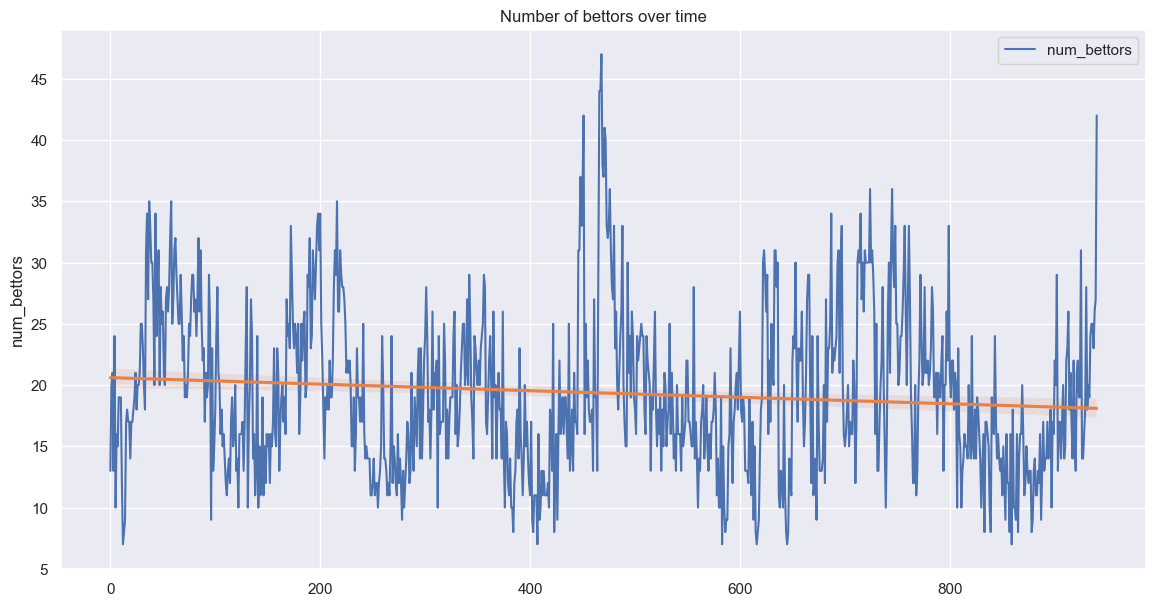

In [8]:
ax = data.plot(y="num_bettors",figsize=(14,7), title="Number of bettors over time")
sns.regplot(x=data.index, y=data.num_bettors, scatter=False, ax=ax)
# sns.kdeplot(y=data.num_bettors)
plt.show()

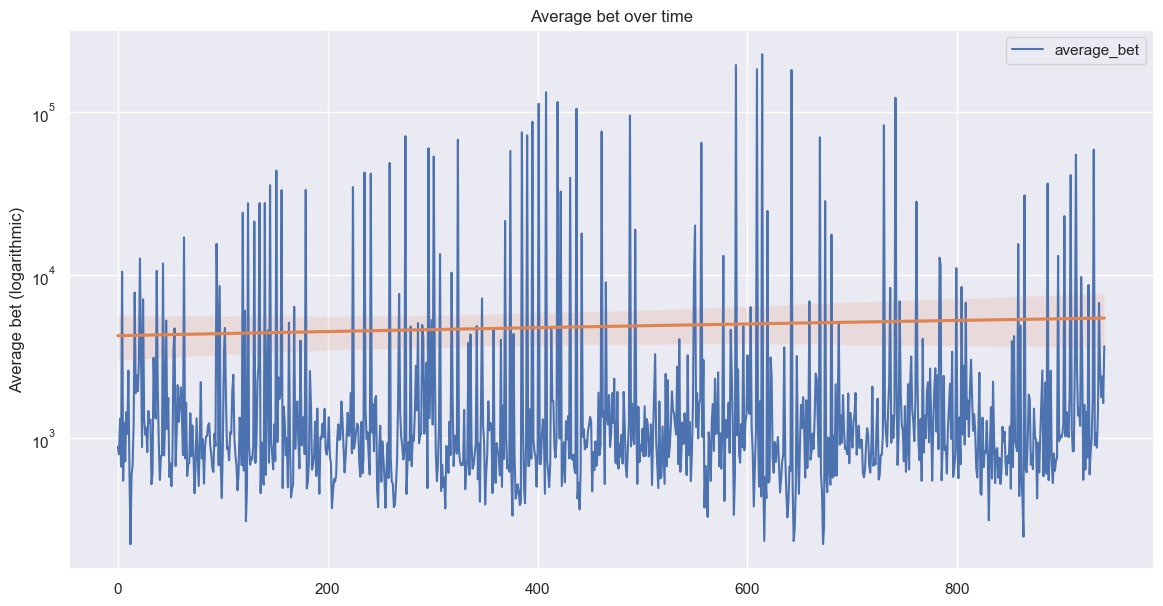

In [9]:
ax = nonzero_bets.plot(y="average_bet", logy=True, figsize=(14,7), title="Average bet over time")
sns.regplot(x=nonzero_bets.index, y=nonzero_bets.average_bet, scatter=False, ax=ax)
ax.set(ylabel="Average bet (logarithmic)")
plt.show()

<Figure size 640x480 with 0 Axes>

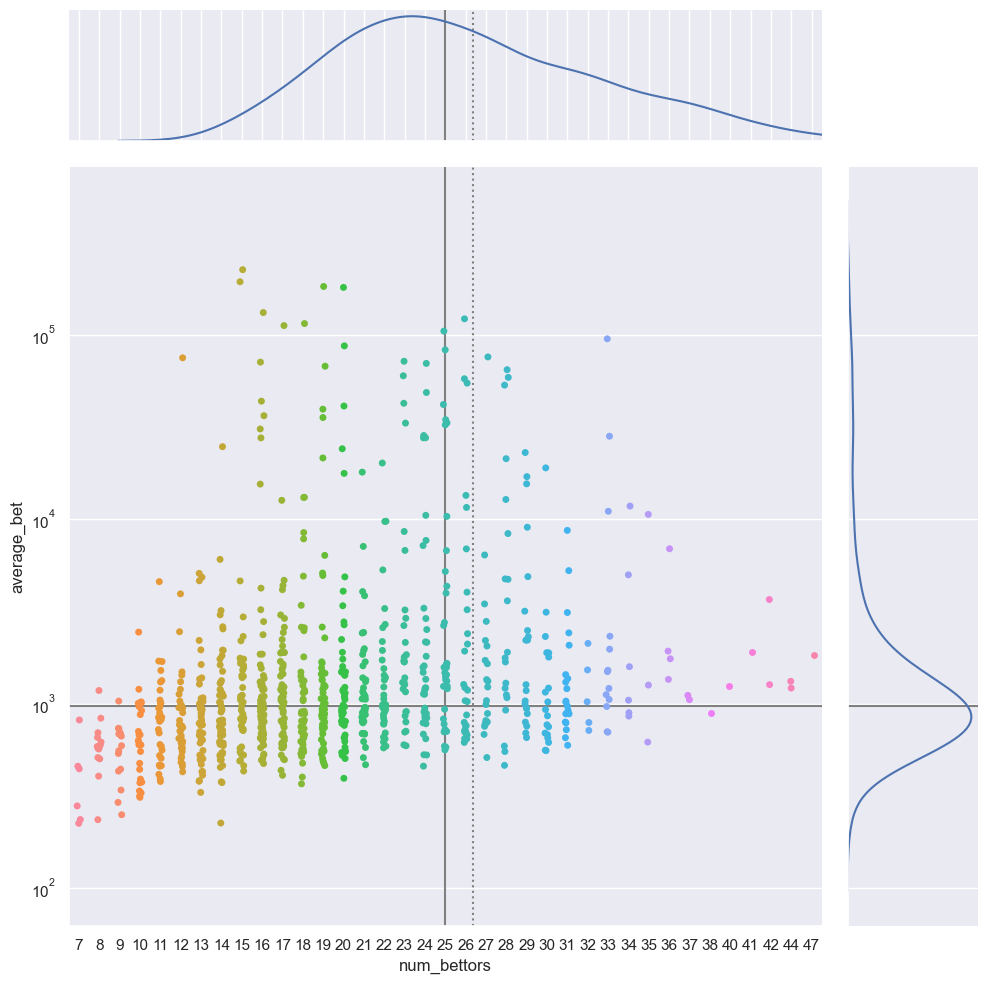

<Figure size 640x480 with 0 Axes>

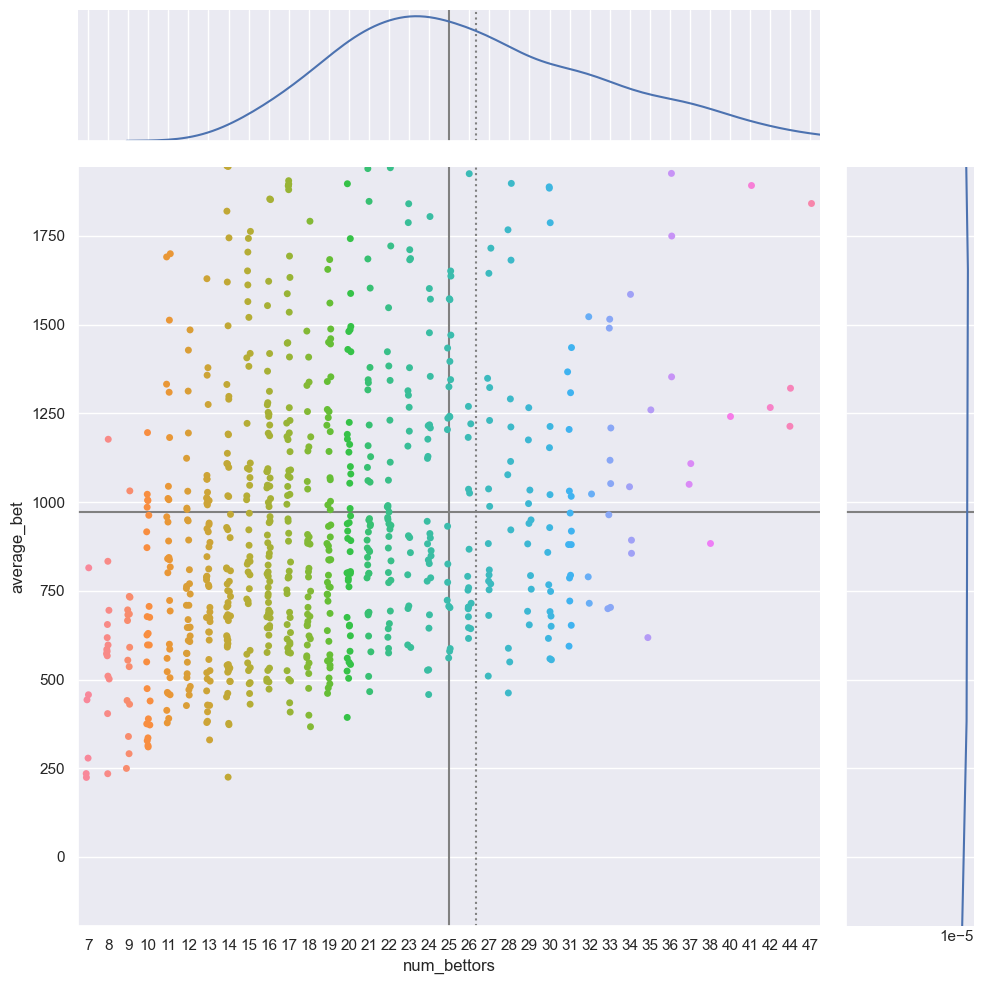

In [10]:
def fill_plot():
    g.refline(x=x.mean(), linestyle=":")
    g.refline(x=x.median(), y=y.median(), linestyle="-")
    sns.stripplot(x=x, y=y, s=5, ax=g.ax_joint)
    sns.kdeplot(x=x, ax=g.ax_marg_x)
    sns.kdeplot(y=y, ax=g.ax_marg_y)
    plt.xticks(rotation=90)
    
x, y = nonzero_bets.num_bettors, nonzero_bets.average_bet

f = plt.figure()
g = sns.JointGrid(x=x, y=y,
                   xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                   height=10,
                  )
g.ax_joint.set_yscale("log")
fill_plot()

median_thresh = y.median() * 2
if(y.max() > median_thresh * 10):
    f = plt.figure()
    g = sns.JointGrid(x=x, y=y,
                    xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                    height=10,
                    ylim=((-0.1*median_thresh),median_thresh)
                  )
    fill_plot()

plt.show()

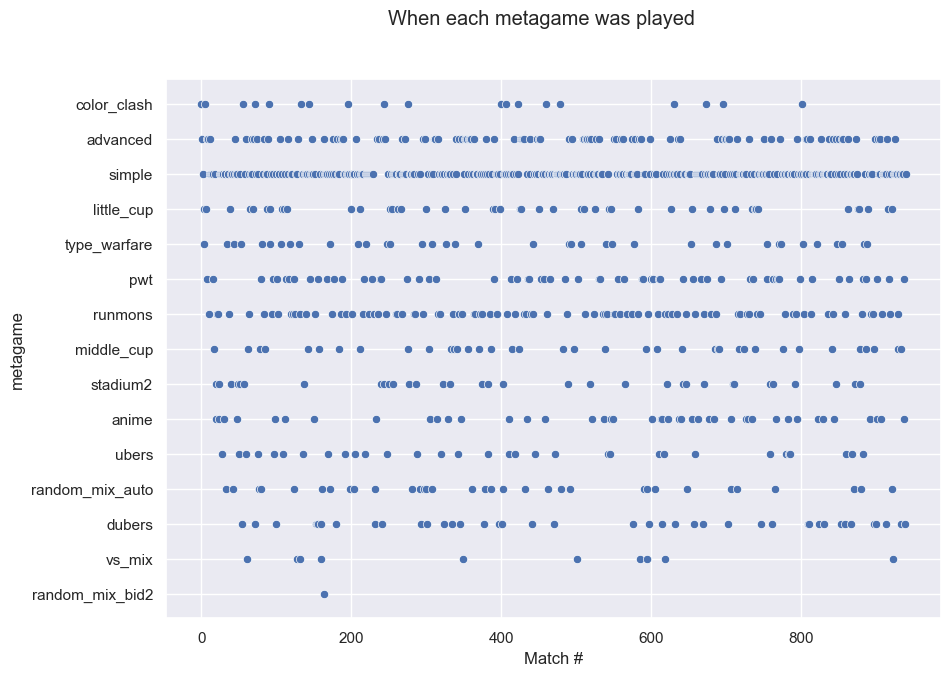

In [11]:
f = plt.figure(figsize=(10,7))
f.suptitle("When each metagame was played")
ax = sns.scatterplot(x=data.index,y=data.metagame)
ax.set(xlabel="Match #")
plt.show()

# Metagames

## Setup

In [12]:
threshold = 0.005 * data.index.max() # remove metagames that appear less than this amount of times, since they are likely token matches
meta = nonzero_bets[nonzero_bets.groupby("metagame").metagame.transform("count") > threshold]
metagames = nonzero_bets.metagame.unique().tolist()
for m in meta.metagame.unique().tolist():
    metagames.remove(m)
print("removed very rare metagames: " + str(metagames))

removed very rare metagames: ['random_mix_bid2']


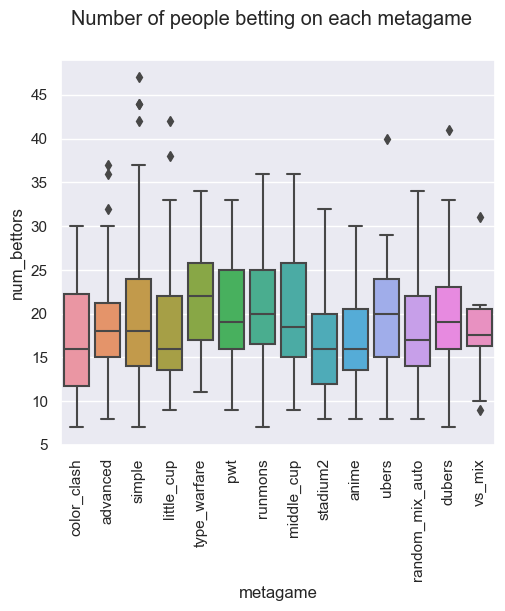

In [13]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
f.suptitle("Number of people betting on each metagame")
sns.boxplot(x=meta.metagame, y=meta.num_bettors)
plt.xticks(rotation=90)
plt.show()

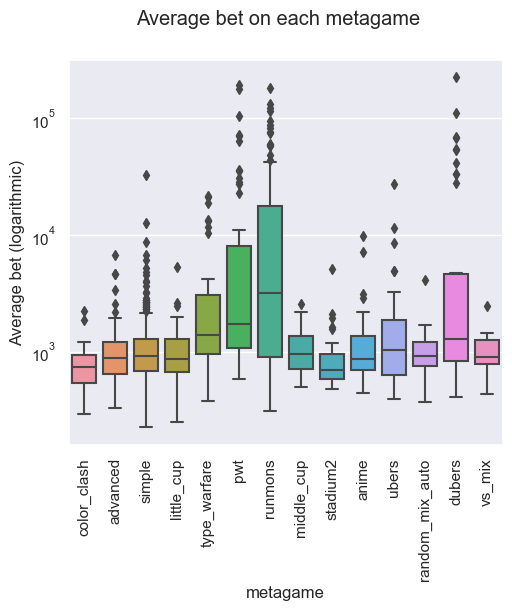

In [14]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
f.suptitle("Average bet on each metagame")
ax = sns.boxplot(x=meta.metagame,y=meta.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.xticks(rotation=90)
plt.show()

# Gimmicks

## Setup

In [15]:
threshold_gim = 5 # absolute minimum amount of data we need to make any meaningful insight
gim = nonzero_bets[nonzero_bets.groupby("gimmick").gimmick.transform("count") > threshold_gim]
gimmicks = data.gimmick.unique().tolist()
for g in gim.gimmick.unique().tolist():
    gimmicks.remove(g)
print("removed infrequently used gimmicks: " + str(gimmicks))

removed infrequently used gimmicks: ['afflicted+manvsmachine_autogenerated', 'italian+manvsmachine_autogenerated', 'random_order+manvsmachine_autogenerated', 'hidden_ace+manvsmachine_autogenerated', 'chameleon+manvsmachine_autogenerated', 'fragile+manvsmachine_autogenerated', 'sketchy+manvsmachine_autogenerated', 'german+manvsmachine_autogenerated', 'shield+manvsmachine_autogenerated', 'hit_and_run+manvsmachine_autogenerated', 'rngod+manvsmachine_autogenerated', 'armor+manvsmachine_autogenerated', '80_perc_hp+manvsmachine_autogenerated', 'defeatist+manvsmachine_autogenerated', 'letdown+manvsmachine_autogenerated', 'rainbow+manvsmachine_autogenerated']


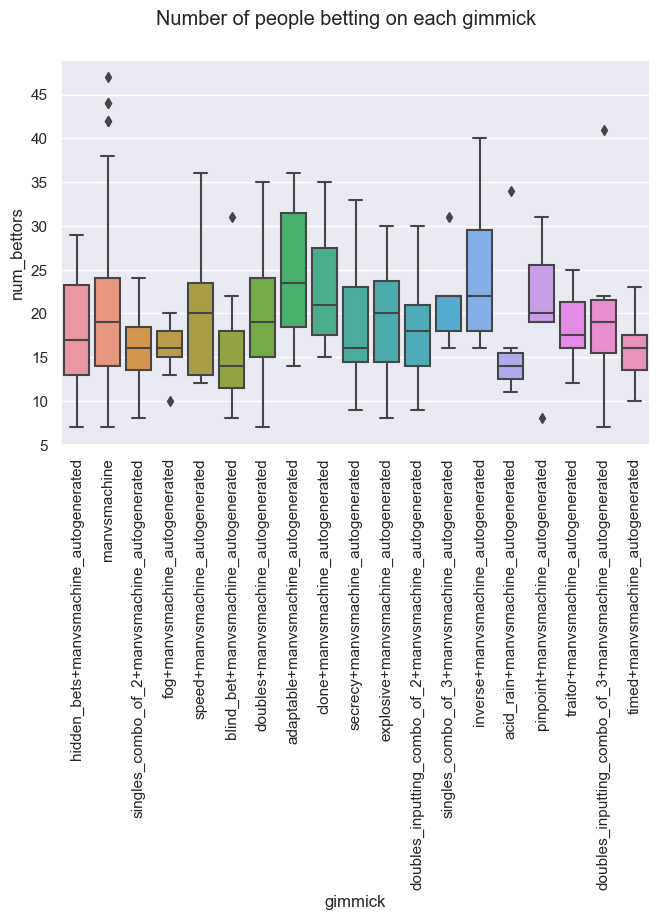

In [16]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Number of people betting on each gimmick")
sns.boxplot(x="gimmick",y="num_bettors",data=gim)
plt.xticks(rotation=90)
plt.show()

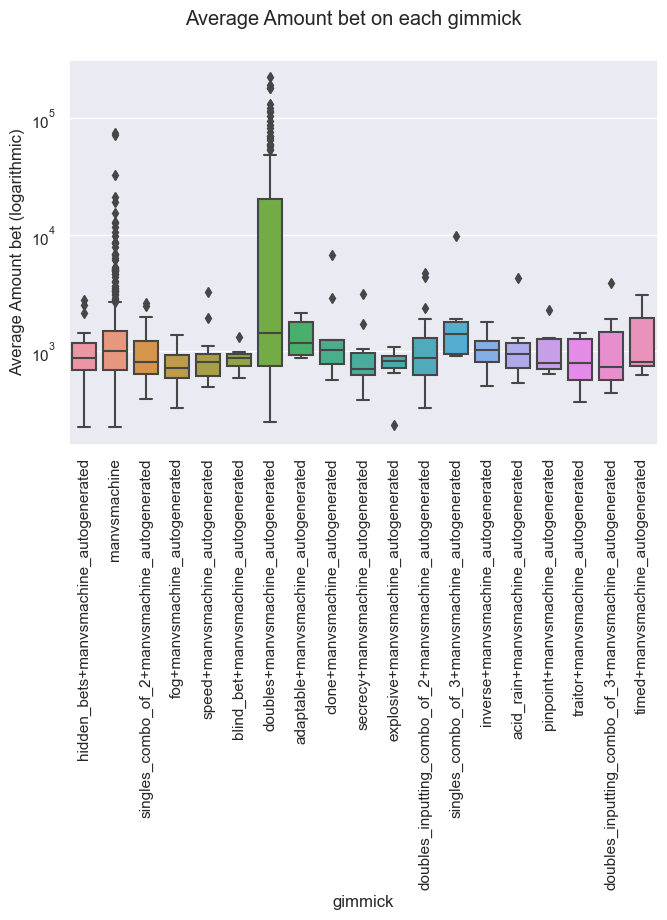

In [17]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Average Amount bet on each gimmick")
ax = sns.boxplot(x=gim.gimmick, y=gim.average_bet)
ax.set(yscale="log", ylabel="Average Amount bet (logarithmic)")
plt.xticks(rotation=90)
plt.show()

# Switching

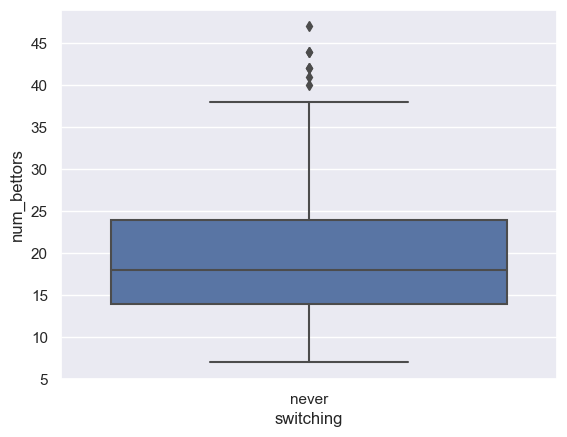

In [18]:
sns.boxplot(x=data.switching,y=data.num_bettors)
plt.show()

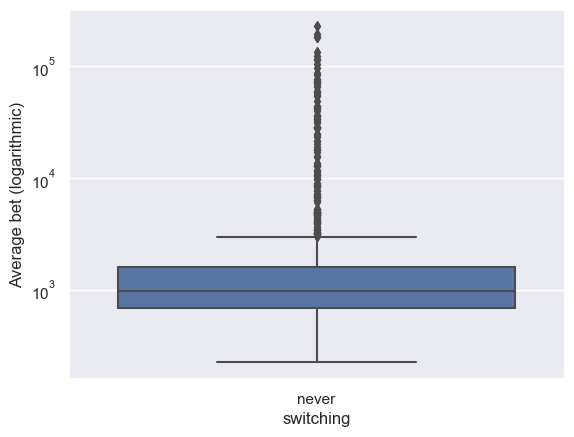

In [19]:
ax = sns.boxplot(x=data.switching,y=data.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.show()

# Odds vs winner
lower odds(<1) indicate more people bet on team 0 (probably red?), while higher(>1) odds indicate more people bet on team 1 (probably blue) 

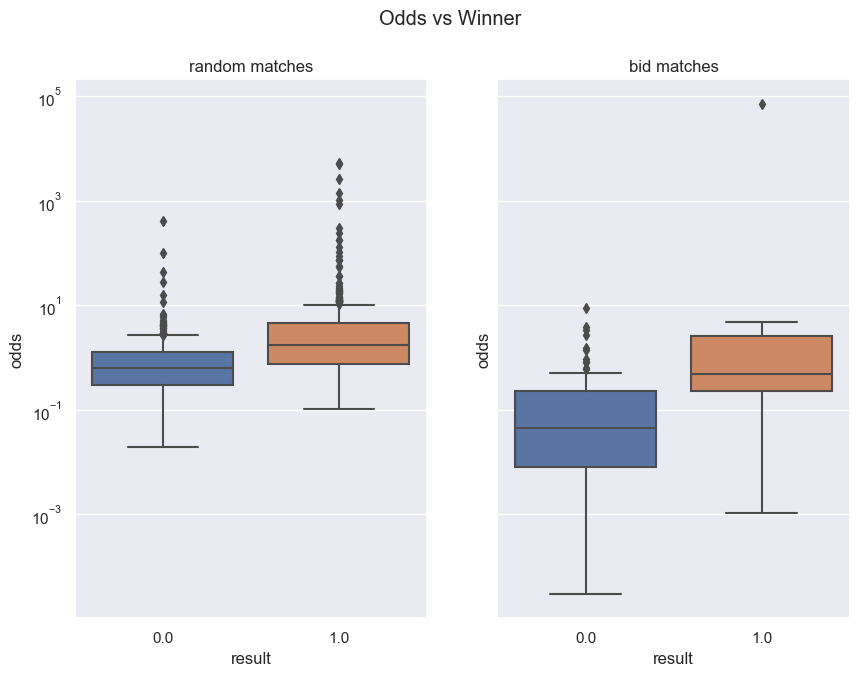

In [20]:
# remove entries where bets are all on 1 team
nonzero_bets = nonzero_bets[nonzero_bets.odds > 0.00001]

auto_matches = nonzero_bets[nonzero_bets.custom == False]
bid_matches = nonzero_bets[nonzero_bets.custom == True]

f, ax = plt.subplots(1, 2, figsize=(10,7),sharey=True)
f.suptitle("Odds vs Winner")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.boxplot(x=auto_matches.result,y=auto_matches.odds, ax=ax[0])
sns.boxplot(x=bid_matches.result,y=bid_matches.odds)

plt.show()

# Bet bonus

C:\Users\Nantz\.conda\envs\tppVis\lib\site-packages\seaborn\regression.py:397: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x, y, **kws)


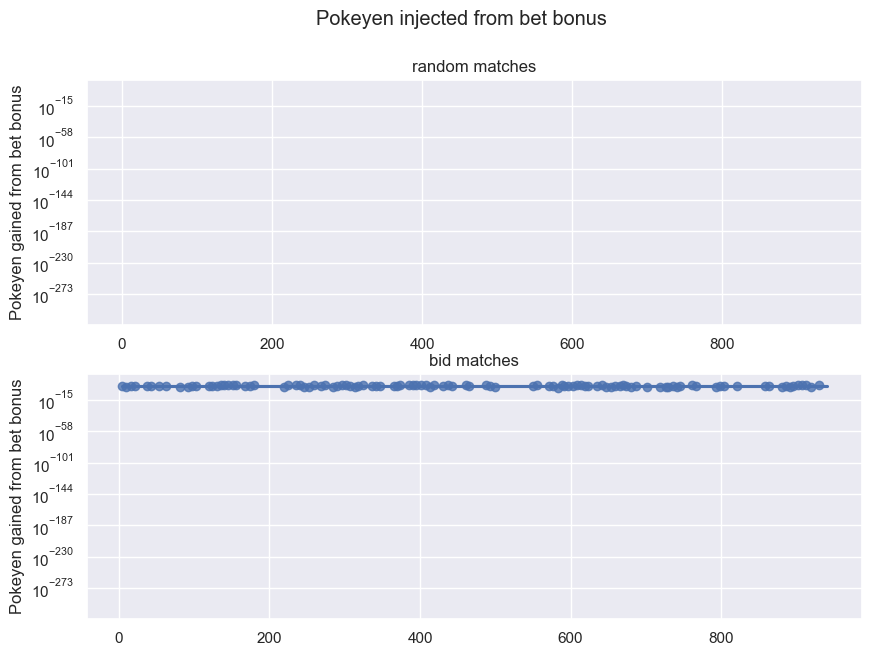

In [21]:
f, ax = plt.subplots(2, 1, figsize=(10,7),sharey=True)
f.suptitle("Pokeyen injected from bet bonus")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax[0])
sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount)

ax[0].set(ylabel="Pokeyen gained from bet bonus")
ax[1].set(ylabel="Pokeyen gained from bet bonus")

plt.show()

# Match predictability

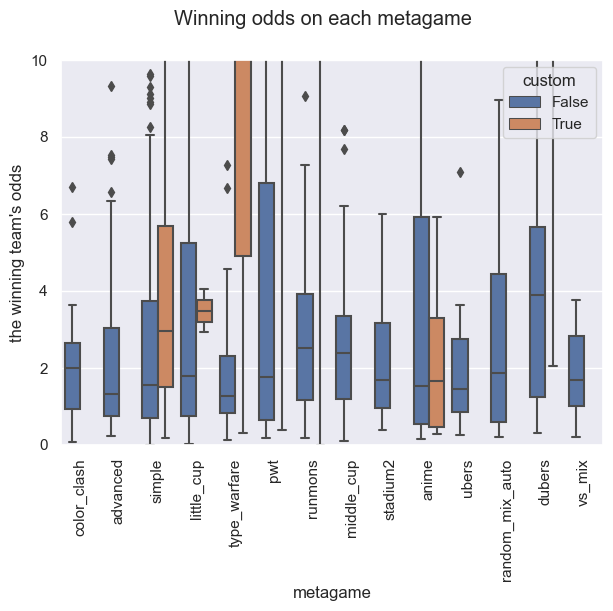

In [22]:
f = plt.figure(figsize=(len(meta.metagame.unique())/2,5))
f.suptitle("Winning odds on each metagame")
ax = sns.boxplot(x=meta.metagame,y=meta.winner_odds, hue=meta.custom)
ax.set(ylabel="the winning team's odds", ylim=(0,10))
plt.xticks(rotation=90)
plt.show()

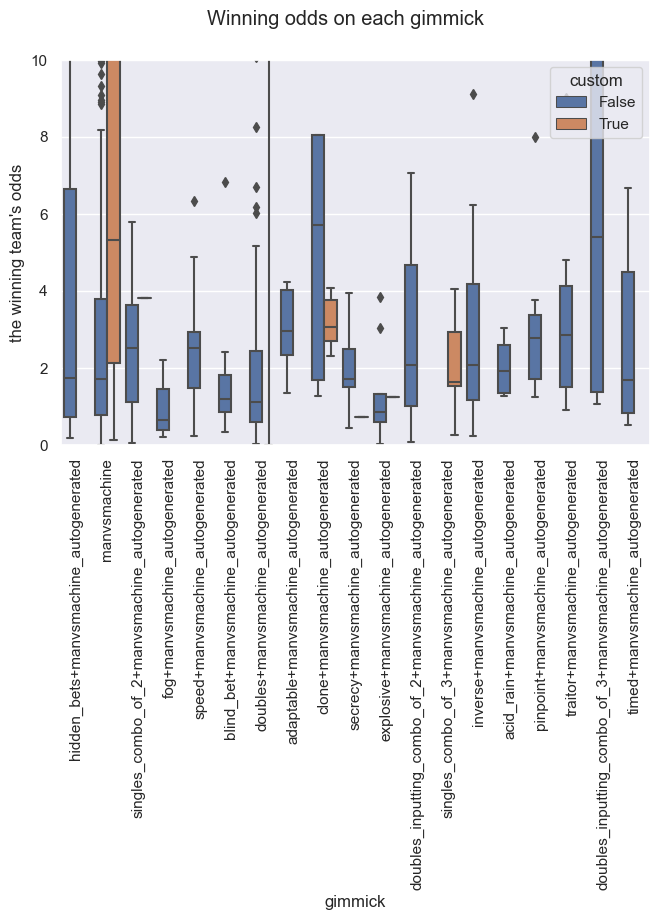

In [23]:
f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
f.suptitle("Winning odds on each gimmick")
ax = sns.boxplot(x=gim.gimmick,y=gim.winner_odds, hue=gim.custom)
ax.set(ylabel="the winning team's odds", ylim=(0,10))
plt.xticks(rotation=90)
plt.show()